#### Produce transfer function between HS2 and EcoPuck data

This Notebook is part of the auv-python project (private repository at https://github.com/mbari-org/auv-python). It demonstrates how to read and make interactive plots of millions of data points accessed from a STOQS database.

To execute it (for example):

```bash
    cd GitHub  # Or other appropriate directory on your computer
    git clone https://github.com/mbari-org/auv-python.git
    cd auv-python
    poetry install
    poetry shell
    cd notebooks
    jupyter notebook
    # Open this notebook and run it from your browser - interactivity not work in VS Code
```

The urls in the pooch.retrieve() calls  below were generated by going to https://stoqs.shore.mbari.org/stoqs_all_dorado/ and clicking the buttons of the Measured Parameters to be included in the Parquet file. Then clicking the "Measured Parameter Data Access" section and clicking the "Estimate requirements" button to verify that the estimated values are within the available values of the server. 

In [1]:
import holoviews as hv
import hvplot.pandas
import ipywidgets as widgets
import numpy as np
import pandas as pd
import panel as pn
import pooch
import statsmodels.api as sm
from holoviews.operation.datashader import datashade

The hs2_bb700 ecopuck_bbp700 regression from stoqs_all_dorado seen at http://stoqs.mbari.org/p/Po7P_h4 (takes ~3 minutes to load) is:
```
OLS linear regression: ecopuck_bbp700 (m^-1 sr^-1) = 0.000362 * hs2_bb700 (m-1) + 0.000791
```
and doesn't look reasonable.

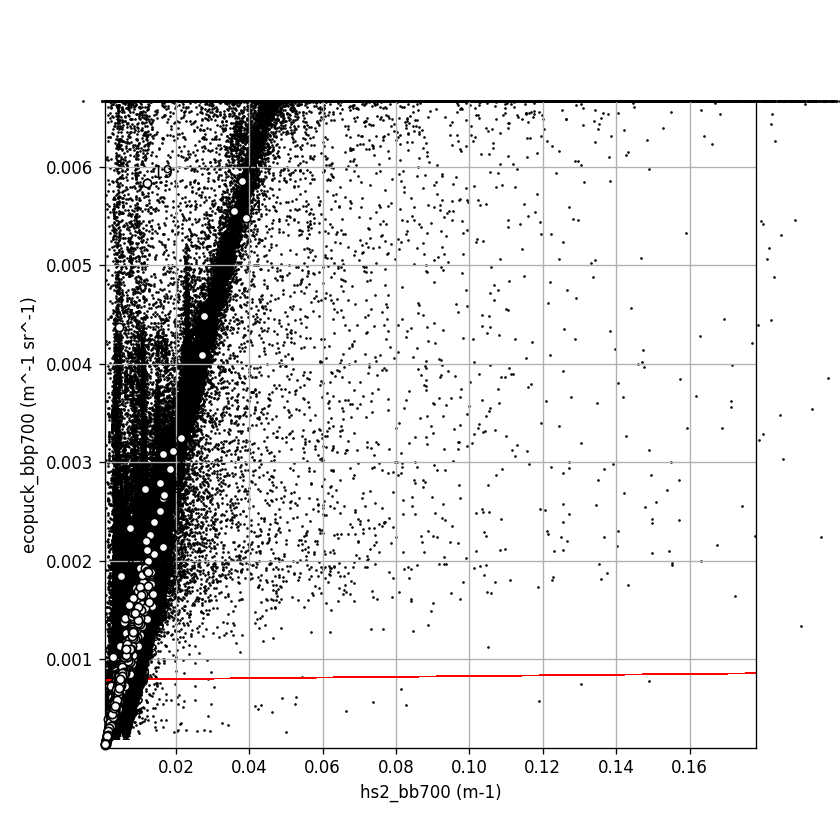

In [2]:
# Many pegged ecopuck_bbp700 values at 0.006669 and egregiously large values of hs2_bb700 skew the results:
from IPython.display import Image
Image(filename="images/dorado_hs2_ecopuck_bbp700_regr1.png")

Let's extract the data from STOQS, do some QC and construct a better regression.

In [3]:
%%time
# Takes several minutes to retrieve the data the first time, thereafter it's read from a local cache
data_file = pooch.retrieve(
    url="https://stoqs.shore.mbari.org/stoqs_all_dorado/api/measuredparameter.parquet?parameter__name=ecopuck_bbp700+%28m%5E-1+sr%5E-1%29&parameter__name=hs2_bb700+%28m-1%29&parameter__name=sigmat&measurement__instantpoint__timevalue__gt=2020-09-01+00%3A00%3A00&measurement__instantpoint__timevalue__lt=2023-11-30+00%3A00%3A00&measurement__depth__gte=-10&measurement__depth__lte=2651&collect=name&include=activity__name",
    known_hash="ddafae5bf32c5b3aea176d2559b93564c6a1f92caf5051d73de45a8c606aedd9",
)
df = pd.read_parquet(data_file)
df.describe()

CPU times: user 3.38 s, sys: 422 ms, total: 3.8 s
Wall time: 3.57 s


name,ecopuck_bbp700 (m^-1 sr^-1),hs2_bb700 (m-1),sigmat
count,2.958474e+06,2.640897e+06,3.089121e+06
mean,8.000957e-04,5.389152e-03,2.552477e+01
std,9.126802e-04,1.381911e-01,4.980304e-01
min,9.618370e-05,-5.239460e-03,2.219897e+01
25%,3.050741e-04,1.760964e-03,2.514274e+01
50%,5.366038e-04,3.234081e-03,2.554874e+01
75%,9.489363e-04,5.953063e-03,2.591462e+01
max,6.669172e-03,1.874973e+02,2.756304e+01


In [4]:
# Remove egregious backscatter values and convert multi-indexes to regular columns in a dataframe modified
x = "hs2_bb700 (m-1)"
y = "ecopuck_bbp700 (m^-1 sr^-1)"
hs2_bb700_max = 0.1            # x axis maximum value for regression
ecopuck_bbp700_max = 0.006     # y axis maximum value for regression

df[x][df[x] > hs2_bb700_max] = np.nan
df[x][df[x] < 0.0] = np.nan
df[y][df[y] > ecopuck_bbp700_max] = np.nan
df[y][df[y] < 0.0] = np.nan
dfm = df.reset_index()
dfm

name,platform,activity__name,timevalue,depth,latitude,longitude,ecopuck_bbp700 (m^-1 sr^-1),hs2_bb700 (m-1),sigmat
0,dorado,dorado_2020.245.00_1S.nc,2020-09-01 19:30:05,-0.078463,36.798569,-121.830941,0.002565,0.012191,NaN
1,dorado,dorado_2020.245.00_1S.nc,2020-09-01 19:30:06,-0.071429,36.798569,-121.830942,0.002565,0.012612,24.919163
2,dorado,dorado_2020.245.00_1S.nc,2020-09-01 19:30:07,-0.045468,36.798568,-121.830944,0.002551,0.012156,24.940766
3,dorado,dorado_2020.245.00_1S.nc,2020-09-01 19:30:08,-0.024187,36.798566,-121.830946,0.002551,0.012080,24.919744
4,dorado,dorado_2020.245.00_1S.nc,2020-09-01 19:30:09,-0.095453,36.798563,-121.830947,0.002521,0.012127,24.945442
...,...,...,...,...,...,...,...,...,...
3117571,dorado_Gulper,dorado_2023.324.00_1S.nc_Gulper_7,2023-11-21 00:31:17,6.491571,36.691881,-121.879710,0.000541,0.002879,24.461110
3117572,dorado_Gulper,dorado_2023.324.00_1S.nc_Gulper_8,2023-11-21 01:23:41,6.292208,36.658452,-121.891895,0.000532,0.002821,24.469303
3117573,dorado_Gulper,dorado_2023.324.00_1S.nc_Gulper_8,2023-11-21 01:23:42,6.748361,36.658438,-121.891867,0.000550,0.002778,24.469576
3117574,dorado_Gulper,dorado_2023.324.00_1S.nc_Gulper_9,2023-11-21 02:23:33,6.270917,36.683295,-121.929687,0.000564,0.003027,24.456465


In [ ]:
# Function to return a generic range selection widget for any column in the dataframe
def sliderType(colmn, range_name):
    return pn.widgets.RangeSlider(
        start=dfm[colmn].min(),
        end=dfm[colmn].max(),
        value=(dfm[colmn].min(), dfm[colmn].max()),
        name=range_name,
        width=600,
        step=dfm[colmn].max() / 200,
    )

In [ ]:
# Datashade scatter plot of backscatter and flouresence with Depth, Date, & Sigma-t selection widgets
dsticker = pn.widgets.Select(options=['dorado', 'dorado_Gulper'], name='platform')
def dsAUV_df(dsticker):
    df = dfm[dfm['platform'] == dsticker]
    return df

dsdf = hvplot.bind(dsAUV_df, dsticker).interactive()

# Dynamic hvplot will not work unless we use this dskind
dskind = pn.widgets.Select(name='kind', value='scatter', options=['scatter'], visible=False)
dsd = sliderType("depth", "Depth Range")
dss = sliderType("sigmat", "Sigma-t Range")
dst = pn.widgets.DateRangeSlider(
    start=dfm.timevalue.min(),
    end=dfm.timevalue.max(),
    value=(dfm.timevalue.min(), dfm.timevalue.max()),
    name="Date Range",
)
dsplt = dsplt = dsdf[
    (dsdf.depth >= dsd.param.value_start)
    & (dsdf.depth <= dsd.param.value_end)
    & (dsdf.sigmat >= dss.param.value_start)
    & (dsdf.sigmat <= dss.param.value_end)
    & (dsdf.timevalue >= dst.param.value_start)
    & (dsdf.timevalue <= dst.param.value_end)
].hvplot(
    kind=dskind,
    x=x,
    y=y,
    xlim=(0, 0.08),
    ylim=(0, 0.007),
    grid=False,
    title=dsticker,
    datashade=True,
    dynamic=True,
    height=400,
)
dsplt

In [ ]:
# Time series plots
hv.Points(dfm, ['timevalue', x])
hs2_plot = datashade(hv.Points(dfm, ['timevalue', x])).opts(hv.opts.RGB(width=900, height=300))
eco_plot = datashade(hv.Points(dfm, ['timevalue', y])).opts(hv.opts.RGB(width=900, height=300))
(eco_plot + hs2_plot).cols(1)

In [ ]:
# Use statsmodels and datashader to print regression info and make a biplot
dfa = dfm[[x, y]].dropna()
results = sm.OLS(dfa[y], sm.add_constant(dfa[x])).fit()
print(results.summary())
slope_plot = hv.Slope.from_scatter(hv.Scatter(dfa.to_numpy())).opts(line_width=1, color='red')
pts = hv.Points(dfa, [x, y])
title = y + " = " + f"{results.params[1]:.4f}" + " * " + x + " + " + f"{results.params[0]:.4f}"

scatter_plot = datashade(pts).opts(width=700, height=700, title=title)
scatter_plot * slope_plot